In [17]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
from copy import deepcopy
from scipy.integrate import solve_ivp

from math_functions import *

np.random.seed(1231)

In [18]:
df = pd.read_excel("data/nph_3069_sm_tables2.xls", sheet_name="Sheet1",
                   header=5, skipfooter=5, usecols="A:B,D:P,R:AC") \
    .fillna(0) \
    .drop(0)   \
    .rename(columns={"Unnamed: 0": "Tree", "Unnamed: 1": "Cohort"})
df = df.astype({k: int for k in df.columns[2:]})
df["Tree"] = df["Tree"].replace("a|b", "", regex=True).astype(int)
df

Tree Cohort  VES-01  VES-02  VES-03  VES-04  VES-05  VES-06  VES-07  \
1     37      1       0       0       0       0       0       0       0   
2     38      1       0       0       0       0       0       0       0   
3     39      1       0       0       0       0       0       0       0   
4     40      1       0       0       0       0       0       0       0   
5     42      1       0       0       0       0       0       0       0   
..   ...    ...     ...     ...     ...     ...     ...     ...     ...   
74    64      4       3       0       0       0       0       0       0   
75    83      4       0       1       0       0       0      11       3   
76    85      4       0       0       1       0       0       1       0   
77    86      4       3       0       0       0       0       2       0   
78    90      4       0       1       0       0       0       0       1   

    VES-08  ...  VIN-03  VIN-04  VIN-05  VIN-06  VIN-07  VIN-08  VIN-09  \
1        0  ...       0       0       0       0       0       0       0   
2        0  ...       0       0       0       0       0       0       0   
3        0  ...       0       0       0       0       0       0       0   
4        0  ...       1       0       0       0       0       0       0   
5        0  ...       0       0       0       0       0       0       0   
..     ...  ...     ...     ...     ...     ...     ...     ...     ...   
74       0  ...       0       0       0       0       0       0       0   
75       0  ...       2       0       0       0       0       0       0   
76       0  ...       0       0       1       0       0       0       0   
77       0  ...       0       0       0       0       0       0       0   
78       0  ...       0       0       1       0       0       0       0   

    VIN-10  VIN-11  VIN-12  
1        0       0       0  
2        0       0       0  
3        0       0       0  
4        0       0       0  
5        0       0       0  
..     ...     ...     ...  
74       0       0       0  
75       0       0       0  
76       0       0       0  
77       0       0       0  
78       0       0       0  

[78 rows x 27 columns]

In [19]:
#Initialize graph
B = nx.Graph()

# add genets nodes
B.add_nodes_from(df.columns[2:], bipartite=0)

#Cohort-diameter map
cohort_diameter_map = {1: (0.7, 0.68), 2: (8.1, 5.2), 3: (24.5, 6.2), 4: (46.4, 5.3)}

def calc_carbon(diameter, max_diameter, stress_level=0):
    fraction = diameter/max_diameter
    carbon = np.tanh((fraction - 0.5)*np.pi*2) + stress_level
    return carbon
    
# add tree nodes
for _, row in df.iterrows():
    mean, stdev = cohort_diameter_map[row["Cohort"]]
    B.add_node(row["Tree"], bipartite=1, cohort=row["Cohort"], diameter=abs(np.random.normal(mean, stdev)))

max_diameter = max(nx.get_node_attributes(B, "diameter").values())    

for node in B.nodes():
    if (B.nodes[node]["bipartite"] == 1):
        B.nodes[node]["carbon_value"] = (calc_carbon(B.nodes[node]["diameter"], max_diameter) + 1)*500

edges = []
# add edges between genets and trees
for _, row in df.iterrows():
    for genet, n in row[2:].items():
        if n > 0:
            edges.append((genet, row["Tree"]))
            
B.add_edges_from(edges)
B.remove_nodes_from([x for x in B.nodes() if B.degree(x) == 0])
B.remove_nodes_from(("VES-11", 79)) # disconnected part

Trees: 55, genets: 24


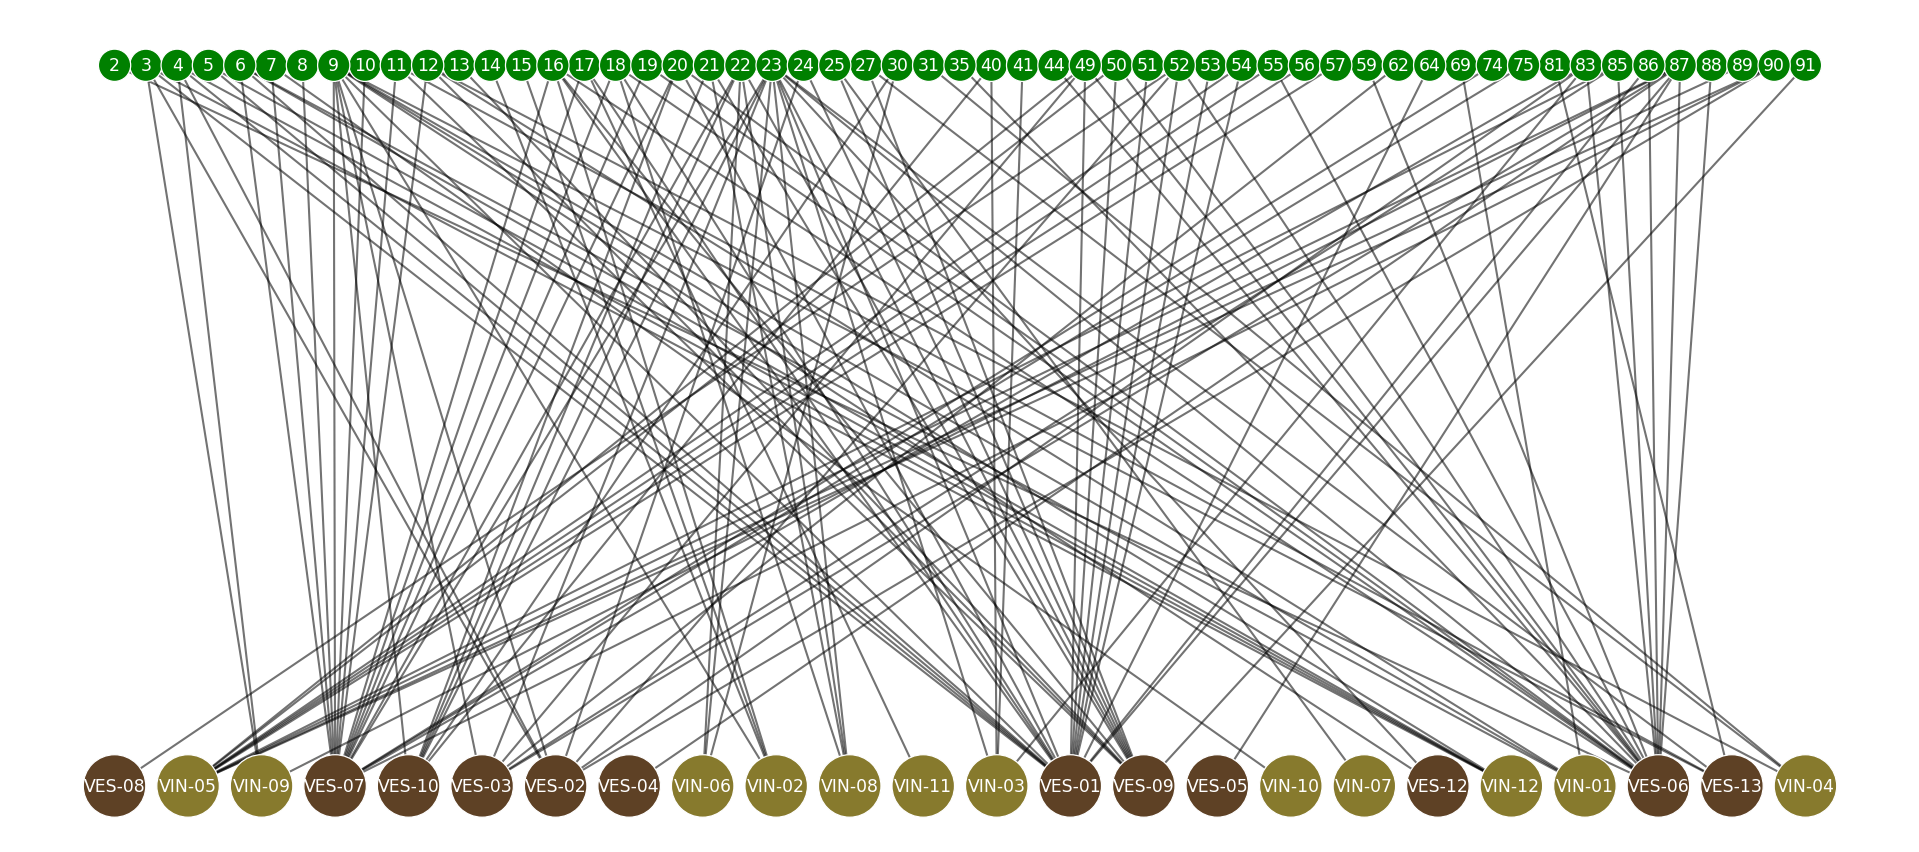

In [20]:
fungi, trees = bipartite.sets(B)
print(f"Trees: {len(trees)}, genets: {len(fungi)}")
pos = nx.bipartite_layout(B, trees, align="horizontal")

node_sizes = []
node_colors = []
for node in B.nodes:
    if B.nodes[node]["bipartite"] == 1:
        node_sizes.append(60)
        node_colors.append("green")
    else:
        node_sizes.append(225)
        if node[0:3] == "VES":
            node_colors.append("#5e4125")
        else:
            node_colors.append("#877a2d")

plt.figure(figsize=(8, 3.5), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(B, pos=pos, node_size=node_sizes, node_color=node_colors, linewidths=0.3, edgecolors="white")
nx.draw_networkx_labels(B, pos, font_color="white", font_size=4.15)
nx.draw_networkx_edges(B, pos, alpha=0.55, width=[0.5 for _ in range(len(B.nodes))])
plt.gca().set_axis_off()
plt.show()

Avg. degree: 19.490909090909092; Max degree: 47 (tree 23)


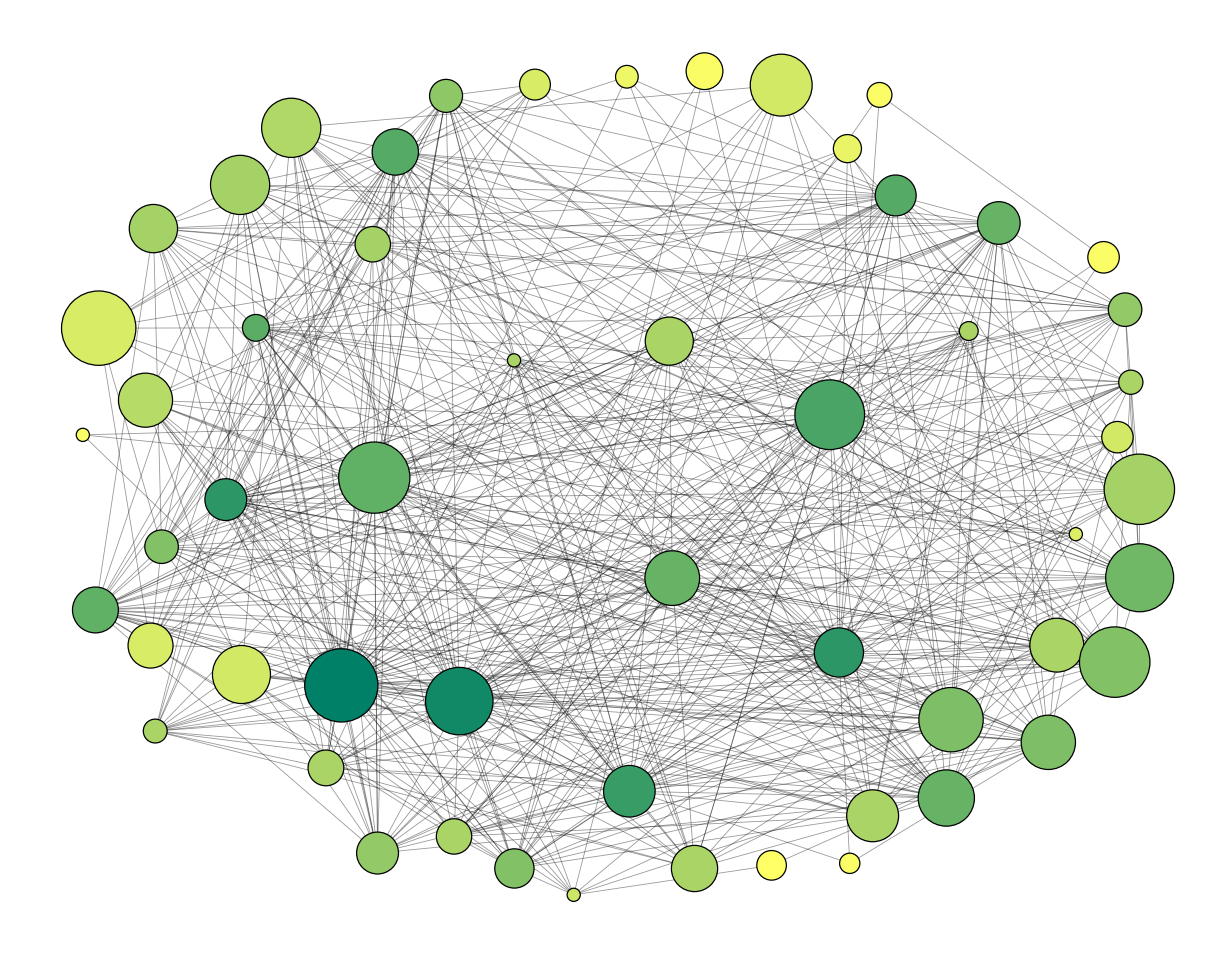

In [21]:
G = bipartite.weighted_projected_graph(B, trees)
degrees_dict = {n: d for n, d in G.degree()}
degrees = list(degrees_dict.values())
sorted_degrees = sorted(degrees_dict, key=degrees_dict.get)
print(f"Avg. degree: {np.average(degrees)}; Max degree: {np.max(degrees)} (tree {sorted_degrees[-1]})")
# print(nx.get_edge_attributes(G, "weight"))

pos = nx.spring_layout(G, k=3,seed=99192, weight=None)

node_sizes = []

for node in G.nodes:
    node_size = max(10, G.nodes[node]["diameter"]*6)
    node_sizes.append(node_size)

plt.figure(figsize=(5, 4), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=degrees,
                       edgecolors="black", linewidths=0.3, cmap=mpl.cm.summer_r)
#nx.draw_networkx_labels(G, pos, font_color="black", font_size=4.1)
nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))])
plt.gca().set_axis_off()
plt.show()

In [22]:
def visualize_carbon_network(G, pos=None):
    if not pos:
        pos = nx.spring_layout(G, k=3,seed=99192, weight=None)
        
    node_sizes = []

    for node in G.nodes:
        node_size = max(10, G.nodes[node]["diameter"]*6)
        node_sizes.append(node_size)
        
    degrees_dict = {n: d for n, d in G.degree()}
    degrees = list(degrees_dict.values())
    carbon_values = list(nx.get_node_attributes(G, "carbon_value").values())
    sorted_degrees = sorted(degrees_dict, key=degrees_dict.get)

    plt.figure(figsize=(5, 4), dpi=300, facecolor="w", frameon=False)
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=carbon_values,
                           edgecolors="black", linewidths=0.3, cmap=mpl.cm.coolwarm)
    #nx.draw_networkx_labels(G, pos, labels = nx.get_node_attributes(G, "carbon_value"), font_color="black", font_size=4.1)
    nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))])
    plt.gca().set_axis_off()
    plt.show()

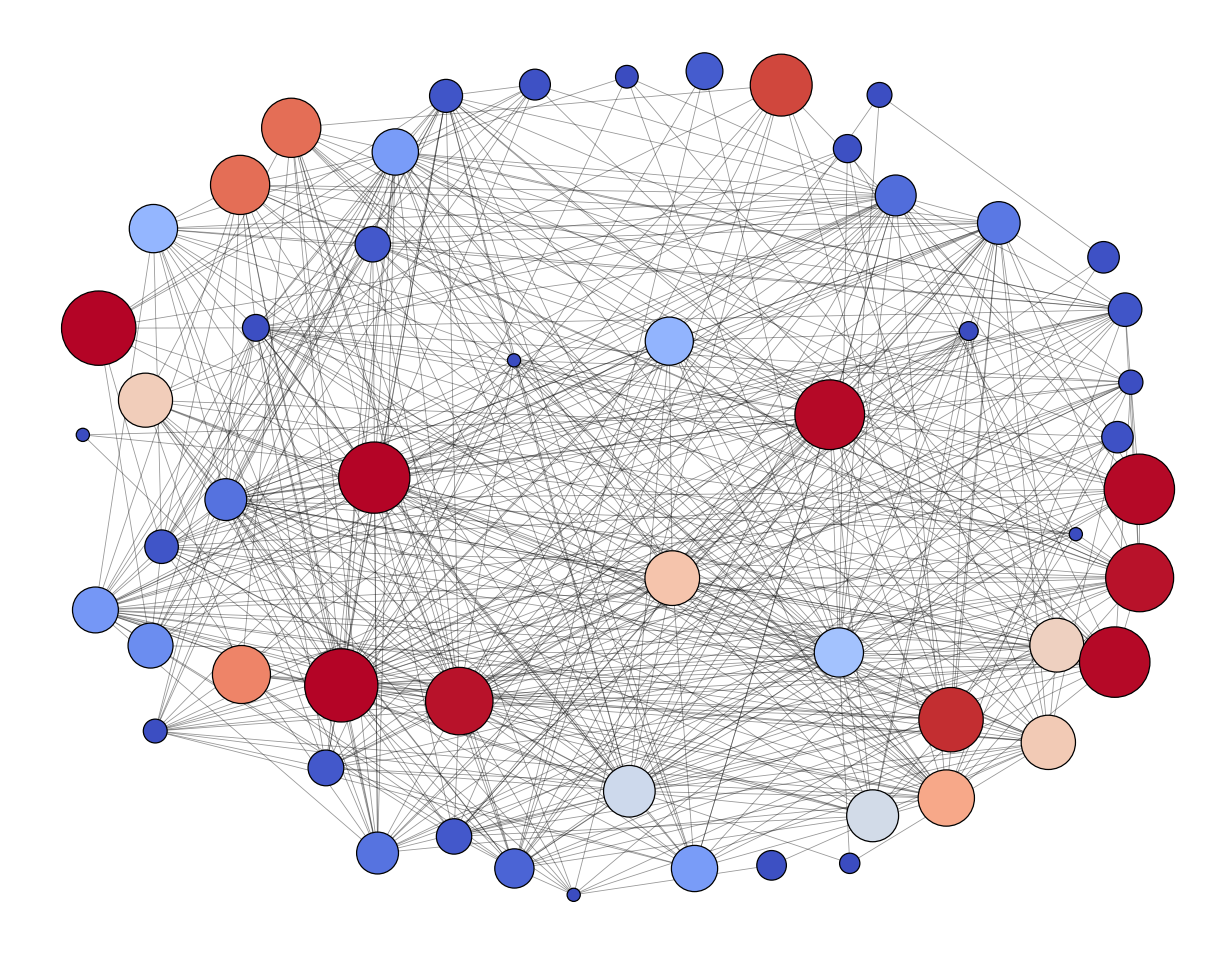

In [23]:
G = bipartite.weighted_projected_graph(B, trees)
visualize_carbon_network(G, pos)

In [59]:
def get_neighbors(G, i):
    node_idx = list(G.nodes)[i]
    node = G.nodes[node_idx]
    return G.neighbors(node_idx)

def split(xs, N):
    return xs[:N], xs[N:]

def split3(xs, N):
    return xs[:N], xs[N:2*N], xs[2*N:]

def pressure_coefficient(r, p=1.0):
    return p + np.exp(-p*r)

def gaussian_uptake(x, A, μ, σ):
    return A*x*np.exp(-(x-μ)**2/σ)

def cbrt(x):
    return np.power(x, 1/3)

def diffusion_dynamics(t, y, G, D_C, N, uptake_ps, f):
    nutrient_root, nutrient_plant, biomass = split3(y, N)
    
    n_r = len(nutrient_root)
    n_p = len(nutrient_plant)
    n_b = len(biomass)
    
    d_root = np.zeros(n_r) 
    d_plant = np.zeros(n_p)
    d_biomass = np.zeros(n_b)
    
    for i,(r_i,p_i,b_i) in enumerate(zip(nutrient_root, nutrient_plant, biomass)):
        node_idx = list(G.nodes)[i]
        node = G.nodes[node_idx]
        node_diameter = node["diameter"]
        
        uptake = r_i * gaussian_uptake(cbrt(b_i), *uptake_ps)
        deposition = f*p_i
        
        d_plant[i] +=  uptake - deposition
        d_root[i]  += -uptake + deposition
        
        # diffusion
        neighbors = get_neighbors(G, i)
        for j in neighbors:
            neighbor_node_idx = list(G.nodes).index(j)
            r_j = nutrient_root[neighbor_node_idx]
            
            d_root[i] += D_C*(r_j - r_i)
    
    return np.concatenate((d_root, d_plant, d_biomass))

In [68]:
N = len(G.nodes)

plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
biomass_0 = np.power(
                np.array(
                    list(
                        nx.get_node_attributes(G, "diameter").values())), 3)
t_range = (0, 600)
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (0.6, 0.0, 40.0)
r_up = 3
f = 1.0e-4

sol = solve_ivp(diffusion_dynamics, t_range, np.concatenate([root_carbon_0, plant_carbon_0, biomass_0]),
                args=(G, D_C, N, uptake_ps, f), dense_output=True)

time_steps = 300
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

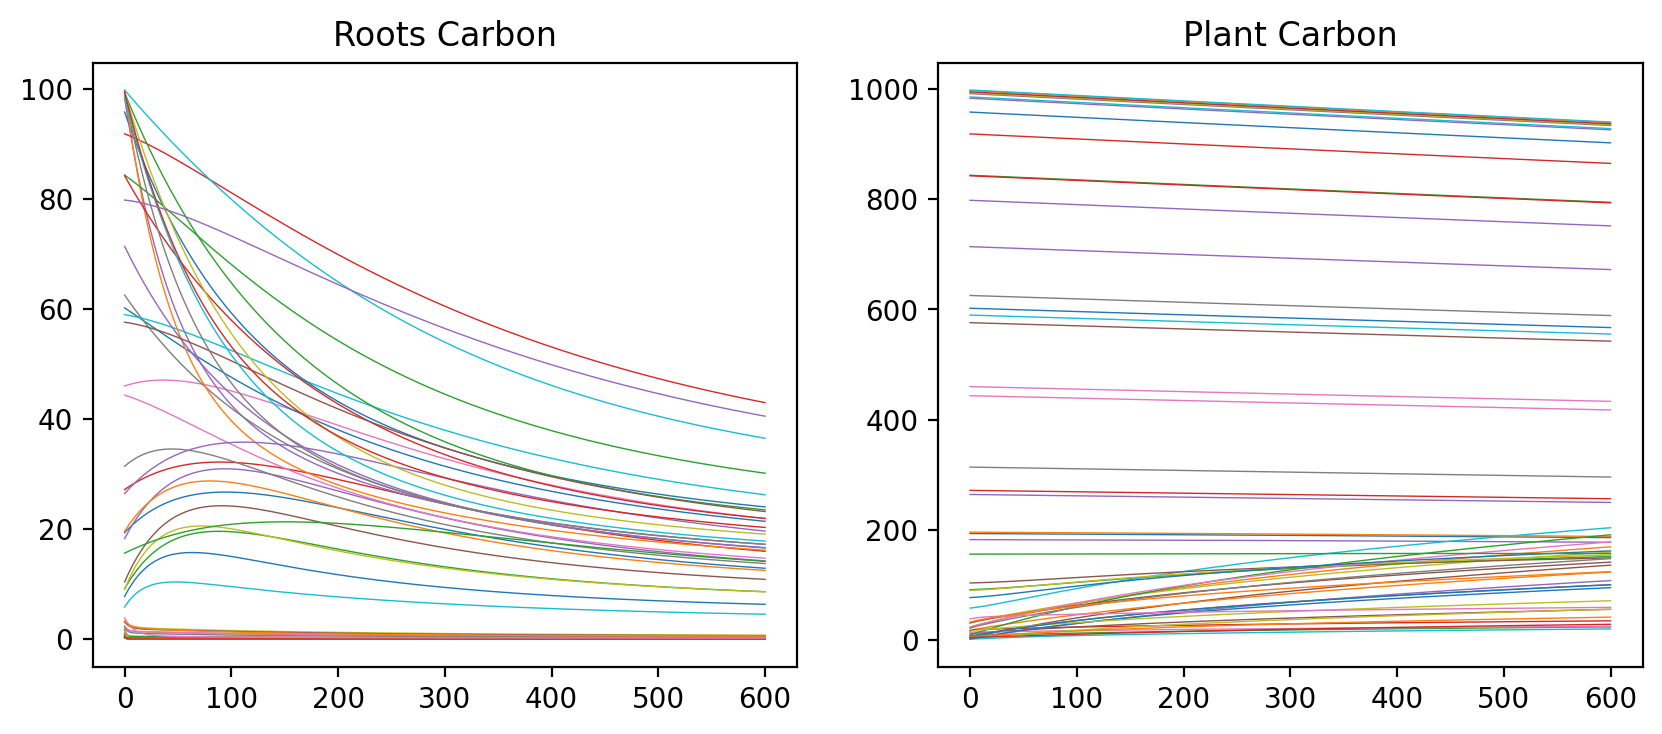

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

axes[0].set_title("Roots Carbon")
for i in range(N):
    axes[0].plot(t, z[i], linewidth=0.5)
    
axes[1].set_title("Plant Carbon")
for i in range(N, 2*N):
    axes[1].plot(t, z[i], linewidth=0.5)

plt.show()

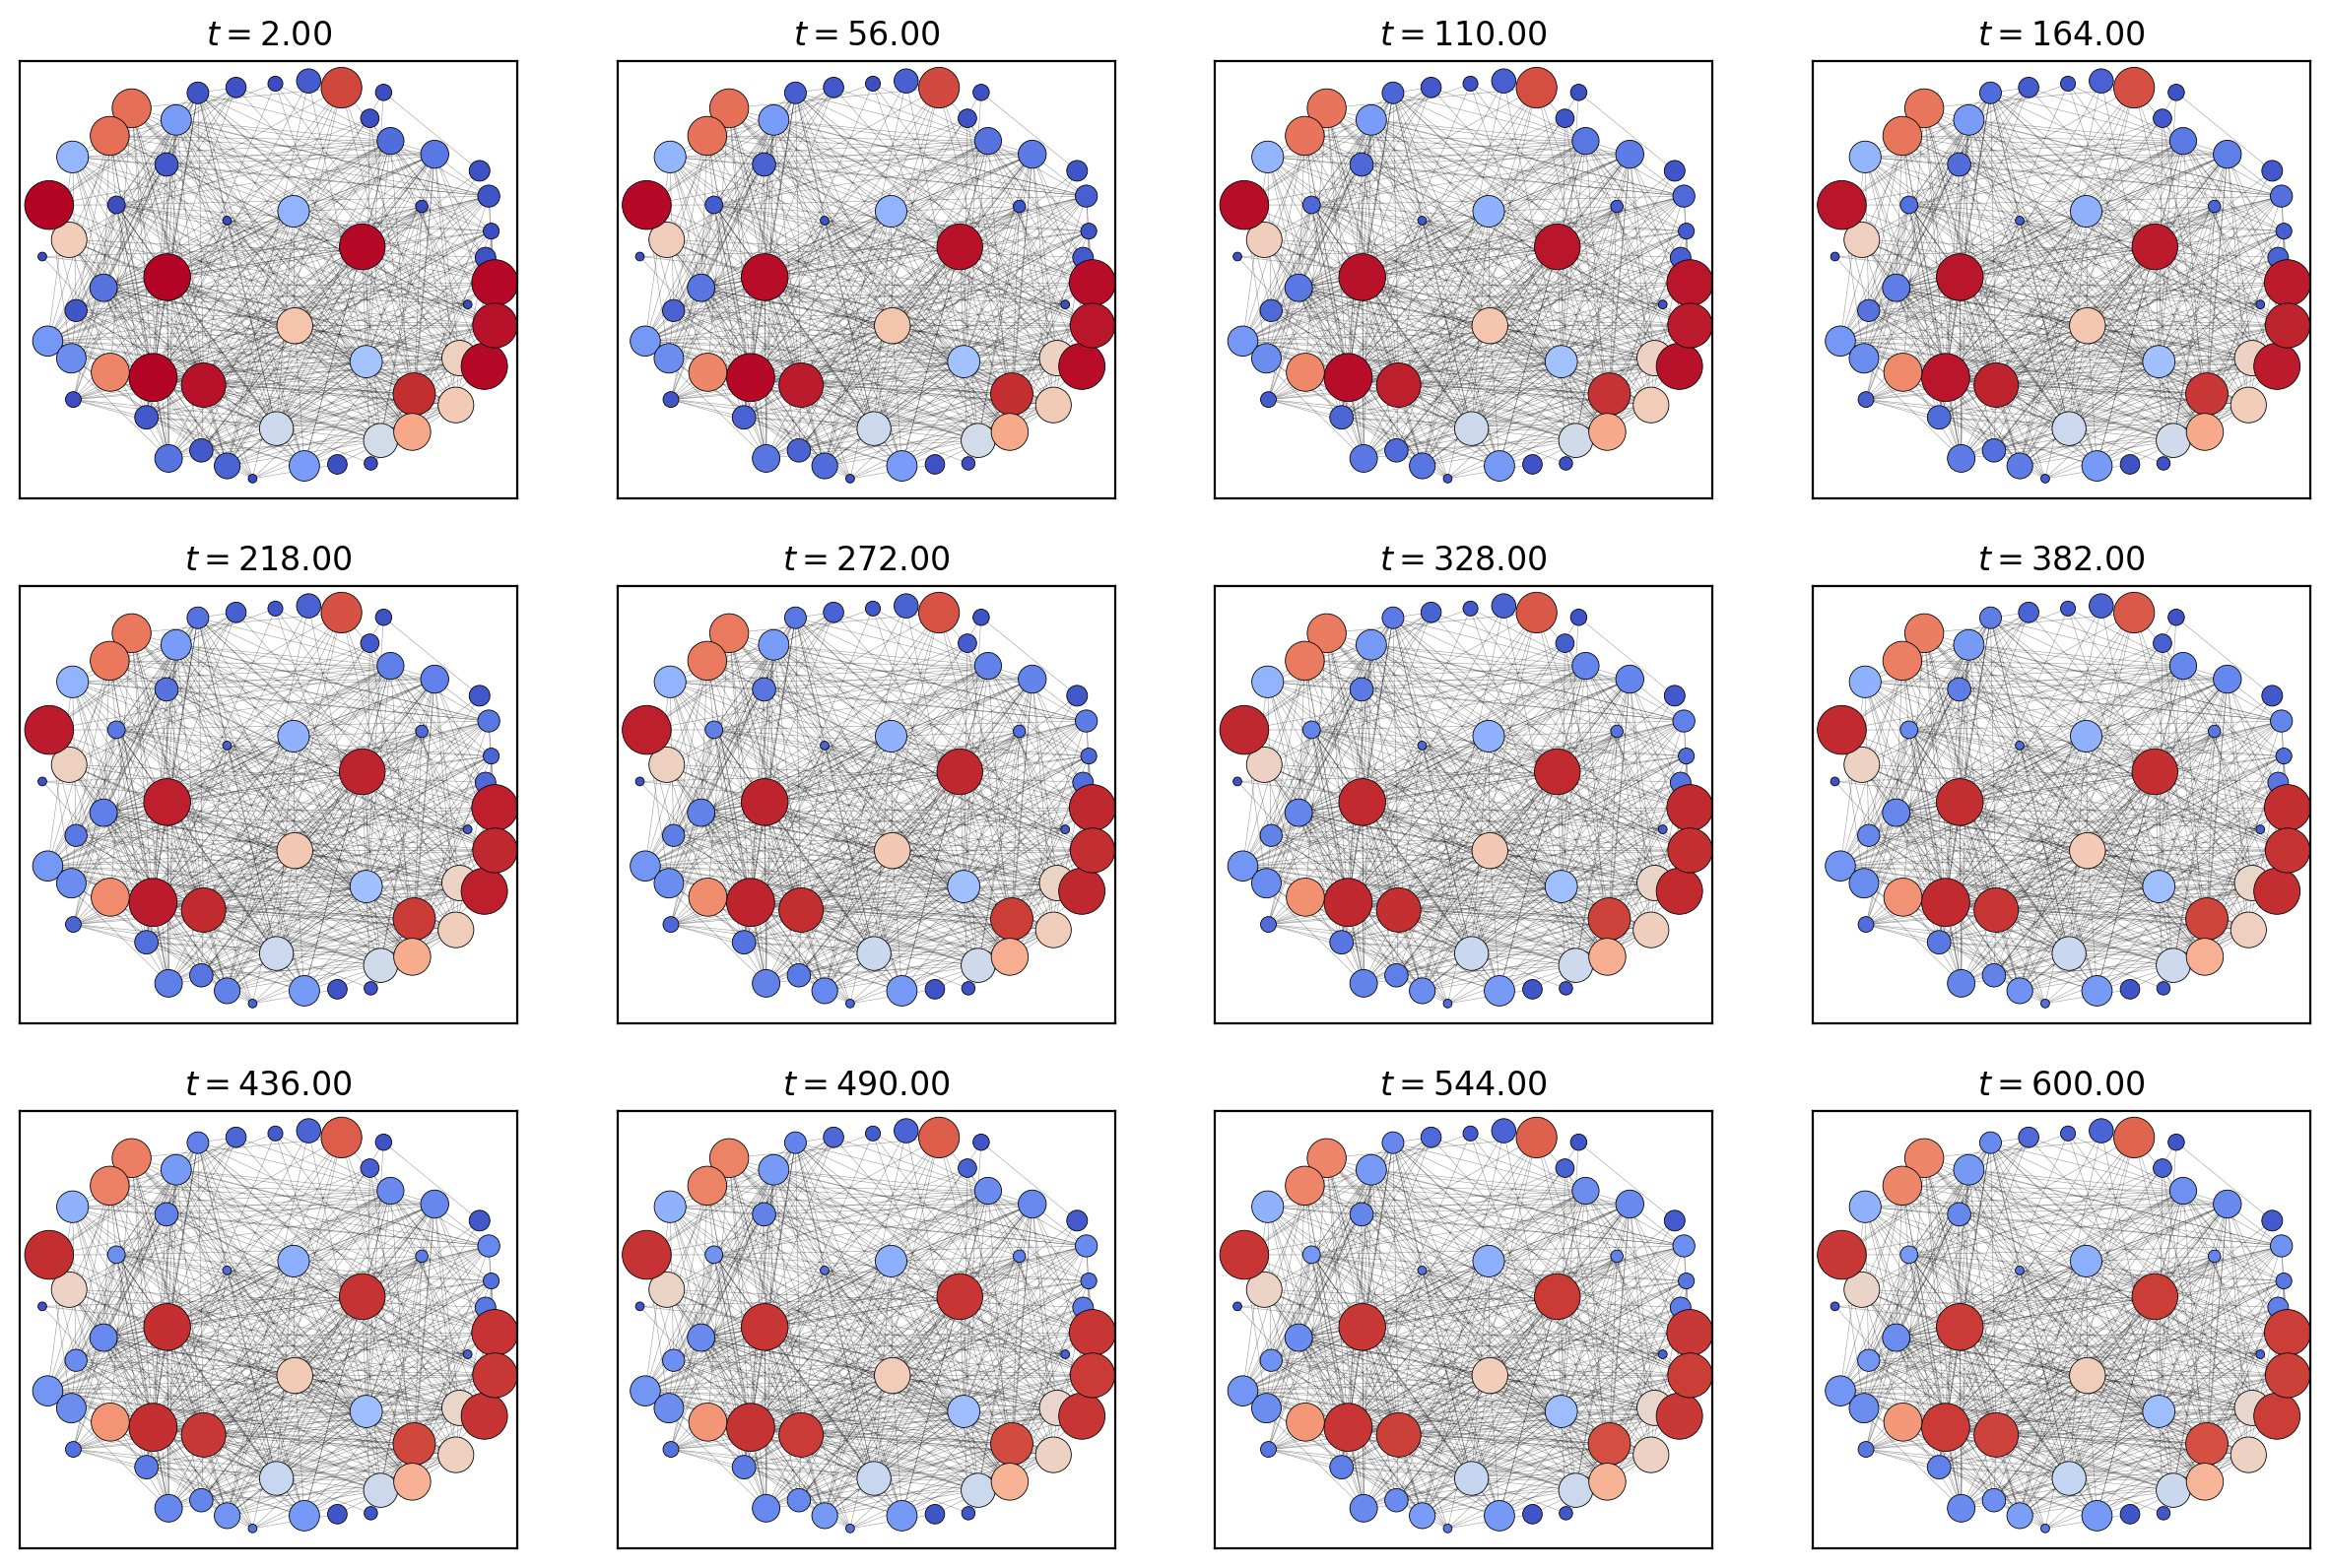

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), dpi=200)

steps = np.linspace(0, time_steps-1, 12, dtype=int)
root_carbon_data = z[N:2*N,:]
min_root_carbon, max_root_carbon = np.min(root_carbon_data), np.max(root_carbon_data)

for j, ax in enumerate(axes.flat):
    ax.set_title(f"$t = {(steps[j]+1)*t_range[1]/time_steps:.2f}$")
    roots_carbon_vals_t = z[:,steps[j]][:N]
    plant_carbon_vals_t = z[:,steps[j]][N:2*N]
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=plant_carbon_vals_t,
                       edgecolors="black", linewidths=0.3, cmap=mpl.cm.coolwarm, ax=ax, vmin=min_root_carbon, vmax=max_root_carbon)
    nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))], ax=ax)
    
plt.show()

In [28]:
raise FuckOff

NameError: name 'FuckOff' is not defined

In [ ]:
def animate_frames(zs, folder):
    import gc
    
    for j in range(time_steps):
        filename = f"movie_frames/{folder}/{j:04}.png"
        fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

        ax.set_title(f"$t = {j*t_range[1]/time_steps:.2f}$")
        roots_carbon_vals_t = zs[:,j][:N]
        plant_carbon_vals_t = zs[:,j][N:]
        nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=plant_carbon_vals_t,
                           edgecolors="black", linewidths=0.3, cmap=mpl.cm.coolwarm, ax=ax, vmin=0, vmax=10)
        nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))], ax=ax)
        plt.tight_layout()
        plt.gca().set_axis_off()
        plt.savefig(filename, facecolor='white', transparent=False)

        # https://stackoverflow.com/questions/7101404/how-can-i-release-memory-after-creating-matplotlib-figures
        plt.clf()
        plt.close()
        gc.collect()
        
# animate_frames(z, "source_sink")

In [ ]:
B_r = B.copy()

B_r.remove_node("VES-01")
B_r.remove_node("VES-06")
G_r = bipartite.weighted_projected_graph(B_r, trees)
visualize_carbon_network(G_r, pos)

In [ ]:
sol_r = solve_ivp(diffusion_dynamics, t_range, root_carbon_0 + plant_carbon_0,
                  args=(G_r, D_C, c1, c2, f, R, N), dense_output=True)

z_r = sol_r.sol(t)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

axes[0].set_title("Roots Carbon")
for i in range(N):
    axes[0].plot(t, z_r[i], linewidth=0.5)
    
axes[1].set_title("Plant Carbon")
for i in range(N, 2*N):
    axes[1].plot(t, z_r[i], linewidth=0.5)

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), dpi=200)

steps = np.linspace(0, time_steps-1, 12, dtype=int)

for j, ax in enumerate(axes.flat):
    ax.set_title(f"$t = {steps[j] + 1}$")

    roots_carbon_vals_t = z_r[:,steps[j]][:N]
    plant_carbon_vals_t = z_r[:,steps[j]][N:]
    
    nx.draw_networkx_nodes(G_r, pos=pos, node_size=node_sizes, node_color=plant_carbon_vals_t,
                       edgecolors="black", linewidths=0.3, cmap=mpl.cm.coolwarm, ax=ax, vmin=0, vmax=10)
    nx.draw_networkx_edges(G_r, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))], ax=ax)
    
plt.show()

In [ ]:
# fig = plt.figure(figsize=(4, 3), dpi=200)
# ax = fig.add_subplot()
# ax.bar(*np.unique(sorted(degrees, reverse=True), return_counts=True))
# ax.set_xlabel("Degree")
# ax.set_ylabel("Number of trees")
# plt.show()

# Modeling Plant Growth (continued)
So, that did not quite work out. The better method might be just going the route of what we did in ABM. Define biomass as diameter cubed

$$b = d^3,$$

and let the biomass obey the following dynamics.

\begin{align}
\dot{b} &= k d^3 p(t) d^{-r}\\
\implies \dot{b} &= kb^{1-\frac{r}{3}}p
\end{align}

where $r$ the power law is incorporated to emulate the slowdown of plant "metabolism" as they grow up. We out here introducing way too many parameters into the model.

In [ ]:
def biomass_growth(b, p, k=1.0, r = 1.2):
    return k*np.power(b, 1-r/3) * p

def split3(xs, N):
    return xs[:N], xs[N:2*N], xs[2*N:]

def uptake_equation(r, b, params):
    raise NotImplementedError
    

def diffusion_dynamics_differential_growth(t, y, G,                     # time, dynamical vars, graph
                                           D_C, c1, c2, f, R_pressure,  # parameters
                                           N, growth_func, k, R_growth,
                                           k_b, uptake_ps):
    nutrient_root, nutrient_plant, biomass = split3(y, N)
    n_r = len(nutrient_root)
    n_p = len(nutrient_plant)
    n_b = len(biomass)
    d_root = np.zeros(n_r) 
    d_plant = np.zeros(n_p)
    d_biomass = np.zeros(n_b)
    
    for i in range(N):
        node_idx = list(G.nodes)[i]
        node = G.nodes[node_idx]
        node_diameter = node["diameter"]
        
        # dynamical variables
        r_i = nutrient_root[i]
        p_i = nutrient_plant[i]
        b_i = biomass[i]
        # pressure_transport = r_i * node_diameter**-R_pressure
        uptake = r_i * uptake_function(b_i, *uptake_params) # TODO: coefficient parameter
        growth = growth_func(b_i, p_i, k=k, r=R_growth)
        deposition = f * p_i
        
        d_root[i]    += deposition - uptake
        d_plant[i]   += uptake - deposition - k_b * growth
        d_biomass[i] += growth
        
        neighbors = get_neighbors(G, i)

        # diffusion term
        for j in neighbors:
            neighbor_node_idx = list(G.nodes).index(j)
            r_j = nutrient_root[neighbor_node_idx]
            throughput = G.edges[node_idx, j]["weight"]
            
            d_root[i] += D_C*throughput*(r_j - r_i)
    
    return np.concatenate((d_root, d_plant, d_biomass))

In [ ]:
N = len(G.nodes)

root_carbon_0 = plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
biomass_0 = np.power(np.array(list(nx.get_node_attributes(G, "diameter").values())), 3)

x_0 = np.concatenate([root_carbon_0, plant_carbon_0, biomass_0])

t_range = (0, 600)
D_C = 0.001 # carbon diffusion coeff
c1 = 0.012 # photosynthesis coefficient 
c2 = 0.01 # carbon decay/respiration
R_pressure = 1.8 # pressure transport power law
R_growth = 1.45 # growth power law
f = 0.01 # fraction of plant carbon transmitted to roots
k = 0.1
k_b = 0.01
uptake_params = (1.0e5, 1.0, 1.0)  # TODO: tweak

G_dcopy = deepcopy(G)
sol = solve_ivp(diffusion_dynamics_differential_growth, t_range, x_0,
                args=(G_dcopy, D_C, c1, c2, f, R_pressure, N, biomass_growth, k, R_growth, k_b, uptake_params), dense_output=True, method="BDF")

# time_steps = 300
time_steps = 20
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), dpi=200)

steps = np.linspace(0, time_steps-1, 12, dtype=int)

biomass_data = z[2*N:,:]
max_biomass = np.max(biomass_data)

plant_carbon_data = z[N:2*N,:]
min_plant_carbon, max_plant_carbon = np.min(plant_carbon_data), np.max(plant_carbon_data)

nodes_by_cohort = {1: [], 2: [], 3: [], 4: []}
node_list = list(G.nodes)

for node in G.nodes:
    nodes_by_cohort[G.nodes[node]["cohort"]].append(node)

for j, ax in enumerate(axes.flat):
    ax.set_title(f"$t = {steps[j] + 1}$")

    roots_carbon_vals_t = z[:,steps[j]][:N]
    plant_carbon_vals_t = z[:,steps[j]][N:2*N]
    biomass_vals_t = (z[:,steps[j]][2*N:3*N])/max_biomass * 500

    edges = nx.draw_networkx_edges(G_dcopy, pos, alpha=0.35, width=[0.15 for _ in range(len(G.nodes))], ax=ax)
    edges.set_zorder(-1)
    for cohort, nodes in nodes_by_cohort.items():
        H = G.subgraph(nodes)
        node_idxs = [node_list.index(node) for node in nodes]
        collection = nx.draw_networkx_nodes(
            H, pos=pos, node_size=biomass_vals_t[node_idxs], node_color=plant_carbon_vals_t[node_idxs],
            edgecolors="black", linewidths=0.4, cmap=mpl.cm.RdYlBu_r, ax=ax, vmin=min_plant_carbon, vmax=max_plant_carbon)
        collection.set_zorder(4-cohort)
    
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), dpi=200)

axes[0].set_title("Roots Carbon")
for i in range(N):
    axes[0].plot(t, z[i], linewidth=0.5)
    
axes[1].set_title("Plant Carbon")
for i in range(N, 2*N):
    axes[1].plot(t, z[i], linewidth=0.5)

axes[2].set_title("Biomass")
for i in range(2*N, 3*N):
    axes[2].plot(t, z[i], linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
def animate_frames_growth(zs, folder):
    import gc
    
    biomass_data = z[2*N:,:]
    max_biomass = np.max(biomass_data)

    plant_carbon_data = z[N:2*N,:]
    min_plant_carbon, max_plant_carbon = np.min(plant_carbon_data), np.max(plant_carbon_data)

    nodes_by_cohort = {1: [], 2: [], 3: [], 4: []}
    node_list = list(G.nodes)
    
    for node in G.nodes:
        nodes_by_cohort[G.nodes[node]["cohort"]].append(node)
    
    for j in range(time_steps):
        filename = f"movie_frames/{folder}/{j:04}.png"
        fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

        ax.set_title(f"$t = {j*t_range[1]/time_steps:.2f}$")
        roots_carbon_vals_t = z[:,j][:N]
        plant_carbon_vals_t = z[:,j][N:2*N]
        biomass_vals_t = (z[:,j][2*N:3*N])/max_biomass * 500

        edges = nx.draw_networkx_edges(G_dcopy, pos, alpha=0.35, width=[0.15 for _ in range(len(G.nodes))], ax=ax)
        edges.set_zorder(-1)
        for cohort, nodes in nodes_by_cohort.items():
            H = G.subgraph(nodes)
            node_idxs = [node_list.index(node) for node in nodes]
            collection = nx.draw_networkx_nodes(
                H, pos=pos, node_size=biomass_vals_t[node_idxs], node_color=plant_carbon_vals_t[node_idxs],
                edgecolors="black", linewidths=0.4, cmap=mpl.cm.RdYlBu_r, ax=ax, vmin=min_plant_carbon, vmax=max_plant_carbon)
            collection.set_zorder(4-cohort)
        plt.tight_layout()
        plt.gca().set_axis_off()
        plt.savefig(filename, facecolor='white', transparent=False)

        # https://stackoverflow.com/questions/7101404/how-can-i-release-memory-after-creating-matplotlib-figures
        plt.clf()
        plt.close()
        gc.collect()
        
# animate_frames_growth(z, "growth")